In [1]:
import os
import sys

dir2 = os.path.abspath("")
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path:
    sys.path.append(dir1)
os.chdir("../..")
os.environ["NUMEXPR_NUM_THREADS"] = "10"

In [2]:
import numpy as np
import pandas as pd
from itertools import accumulate

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import rankdata
from scipy.stats import gmean

Error.  nthreads cannot be larger than environment variable "NUMEXPR_MAX_THREADS" (0)

In [3]:
# Load the metrics file
data = pd.read_csv(os.path.join("results", "aggregation", "metrics_ndcg_10.csv"))

In [4]:
dataset_clusters = [
    ["amazon_cds", "amazon_tv", "gowalla", "mts_library", "amazon_mi", "yelp"],
    ["beeradvocate", "dianping", "douban_movies", "movielens_1m", "reddit", "rekko"],
    ["movielens_10m", "movielens_20m", "ratebeer"],
    [
        "amazon_finefoods",
        "brightkite",
        "douban_books",
        "douban_music",
        "epinions",
        "food",
        "goodreads",
        "retail",
        "tafeng",
    ],
    ["foursquare", "kuairec_full", "kuairec_small"],
    ["netflix", "sber_smm", "sber_zvuk"],
]

In [5]:
# Rename methods according to given mappings
method_rename_map = {
    "recbole_ItemKNN": "ItemKNN",
    "recbole_EASE": "EASE",
    "recbole_MultiVAE": "MultiVAE",
    "recbole_LightGCN": "LightGCN",
    "recbole_LightGCL": "LightGCL",
    "implicit_bpr": "BPR",
    "implicit_als": "ALS",
    "lightfm": "LightFM",
    "recbole_SLIMElastic": "SLIM",
    "most_popular": "MostPop",
    "random": "Random",
}
data["Method"] = data["Method"].map(method_rename_map).fillna(data["Method"])

# Define and sort methods and datasets
method_order = [
    "EASE",
    "LightGCN",
    "MultiVAE",
    "LightGCL",
    "ALS",
    "ItemKNN",
    "LightFM",
    "SLIM",
    "BPR",
    "MostPop",
    "Random",
]

dataset_order = []
for dataset in dataset_clusters:
    dataset_order.extend(dataset)

seps = [len(i) for i in dataset_clusters[:-1]]

/tmp/ipykernel_600329/1695829763.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_data = data.pivot("Method", "Dataset", "Value")


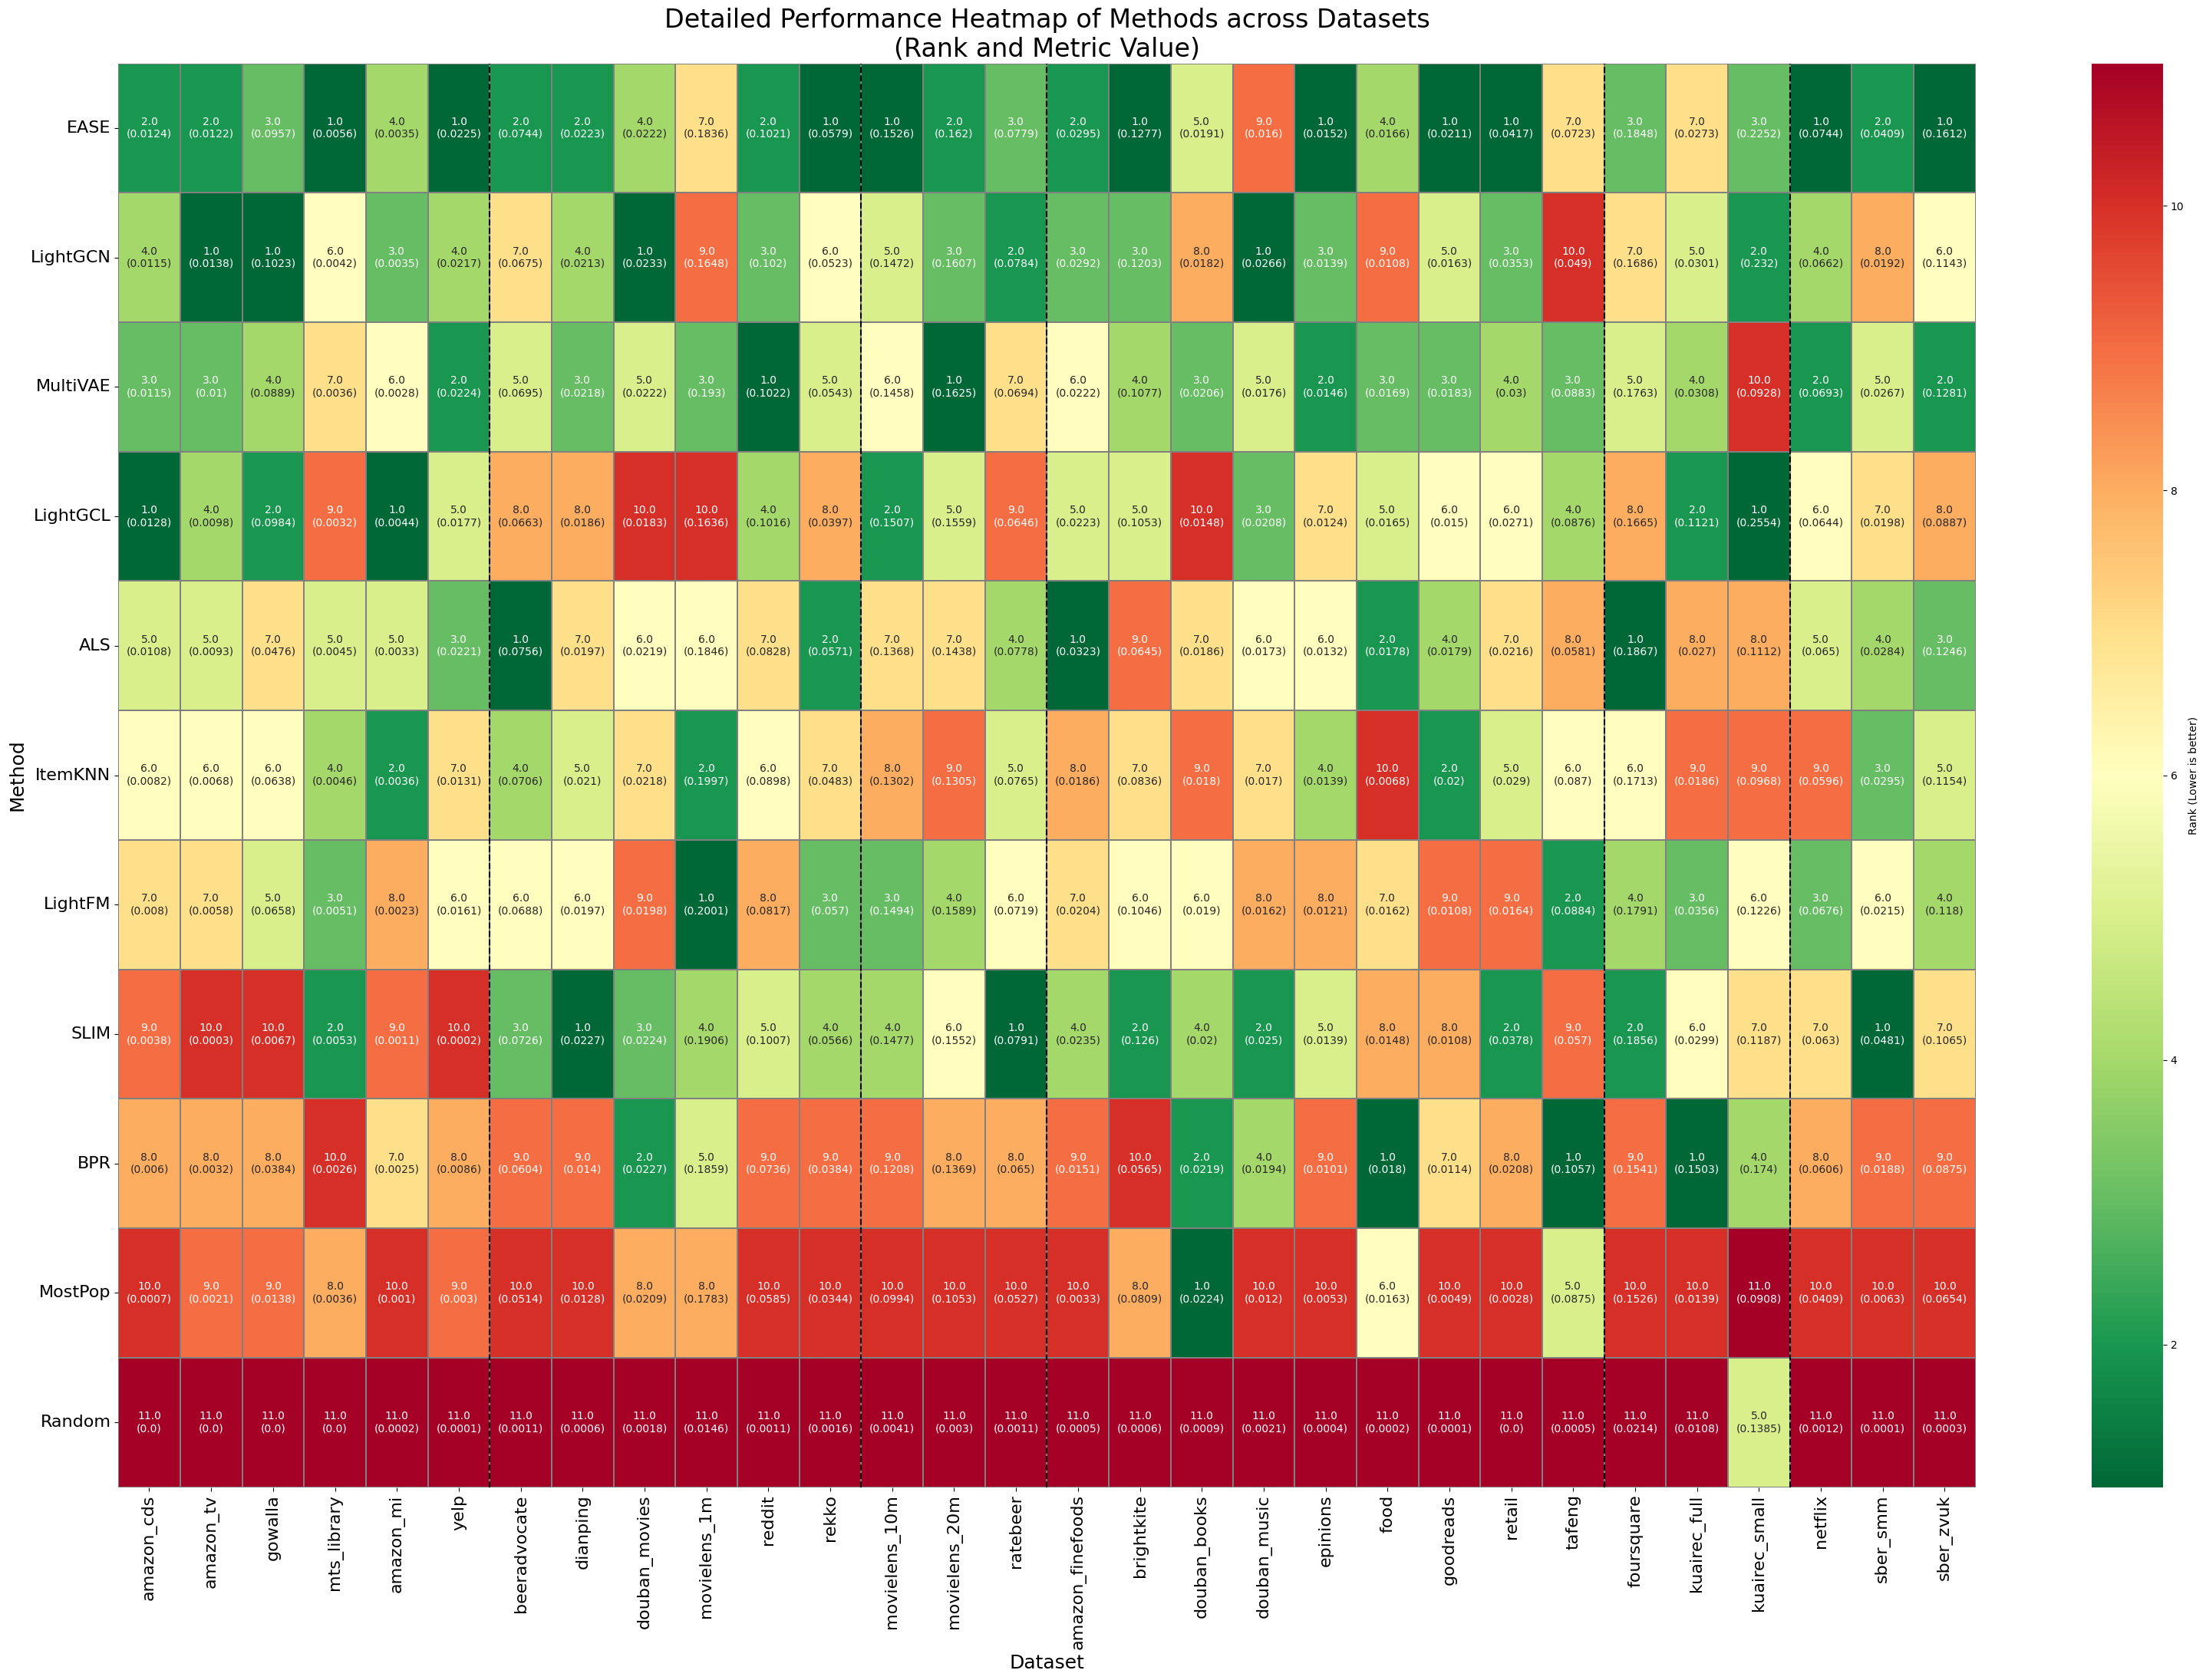

In [6]:
# Pivot the data and sort
# Pivot the data and sort
pivot_data = data.pivot("Method", "Dataset", "Value")
pivot_data = pivot_data.reindex(method_order, axis=0).reindex(columns=dataset_order)

# Calculate ranks across all methods for each dataset
ranks = pivot_data.apply(lambda x: rankdata(-x, method="average"), axis=0)

# Combine ranks with metric values for visualization
combined_info = ranks.astype(str) + "\n(" + pivot_data.round(4).astype(str) + ")"

# Create the heatmap
plt.figure(figsize=(32, 22))
sns.heatmap(
    ranks,
    annot=combined_info,
    fmt="",
    cmap="RdYlGn_r",
    linewidths=0.1,
    linecolor="grey",
    cbar_kws={"label": "Rank (Lower is better)"},
    annot_kws={"size": 10},
)

plt.title(
    "Detailed Performance Heatmap of Methods across Datasets\n(Rank and Metric Value)",
    fontsize=24,
)
plt.xticks(rotation=90, ha="center", fontsize=16)
plt.yticks(rotation=0, fontsize=16)
plt.xlabel("Dataset", fontsize=18)
plt.ylabel("Method", fontsize=18)
plt.tight_layout()
for sep in accumulate(seps):  # Adjusted for correct dataset group separations
    plt.axvline(x=sep, color="black", linestyle="--")
plt.show()

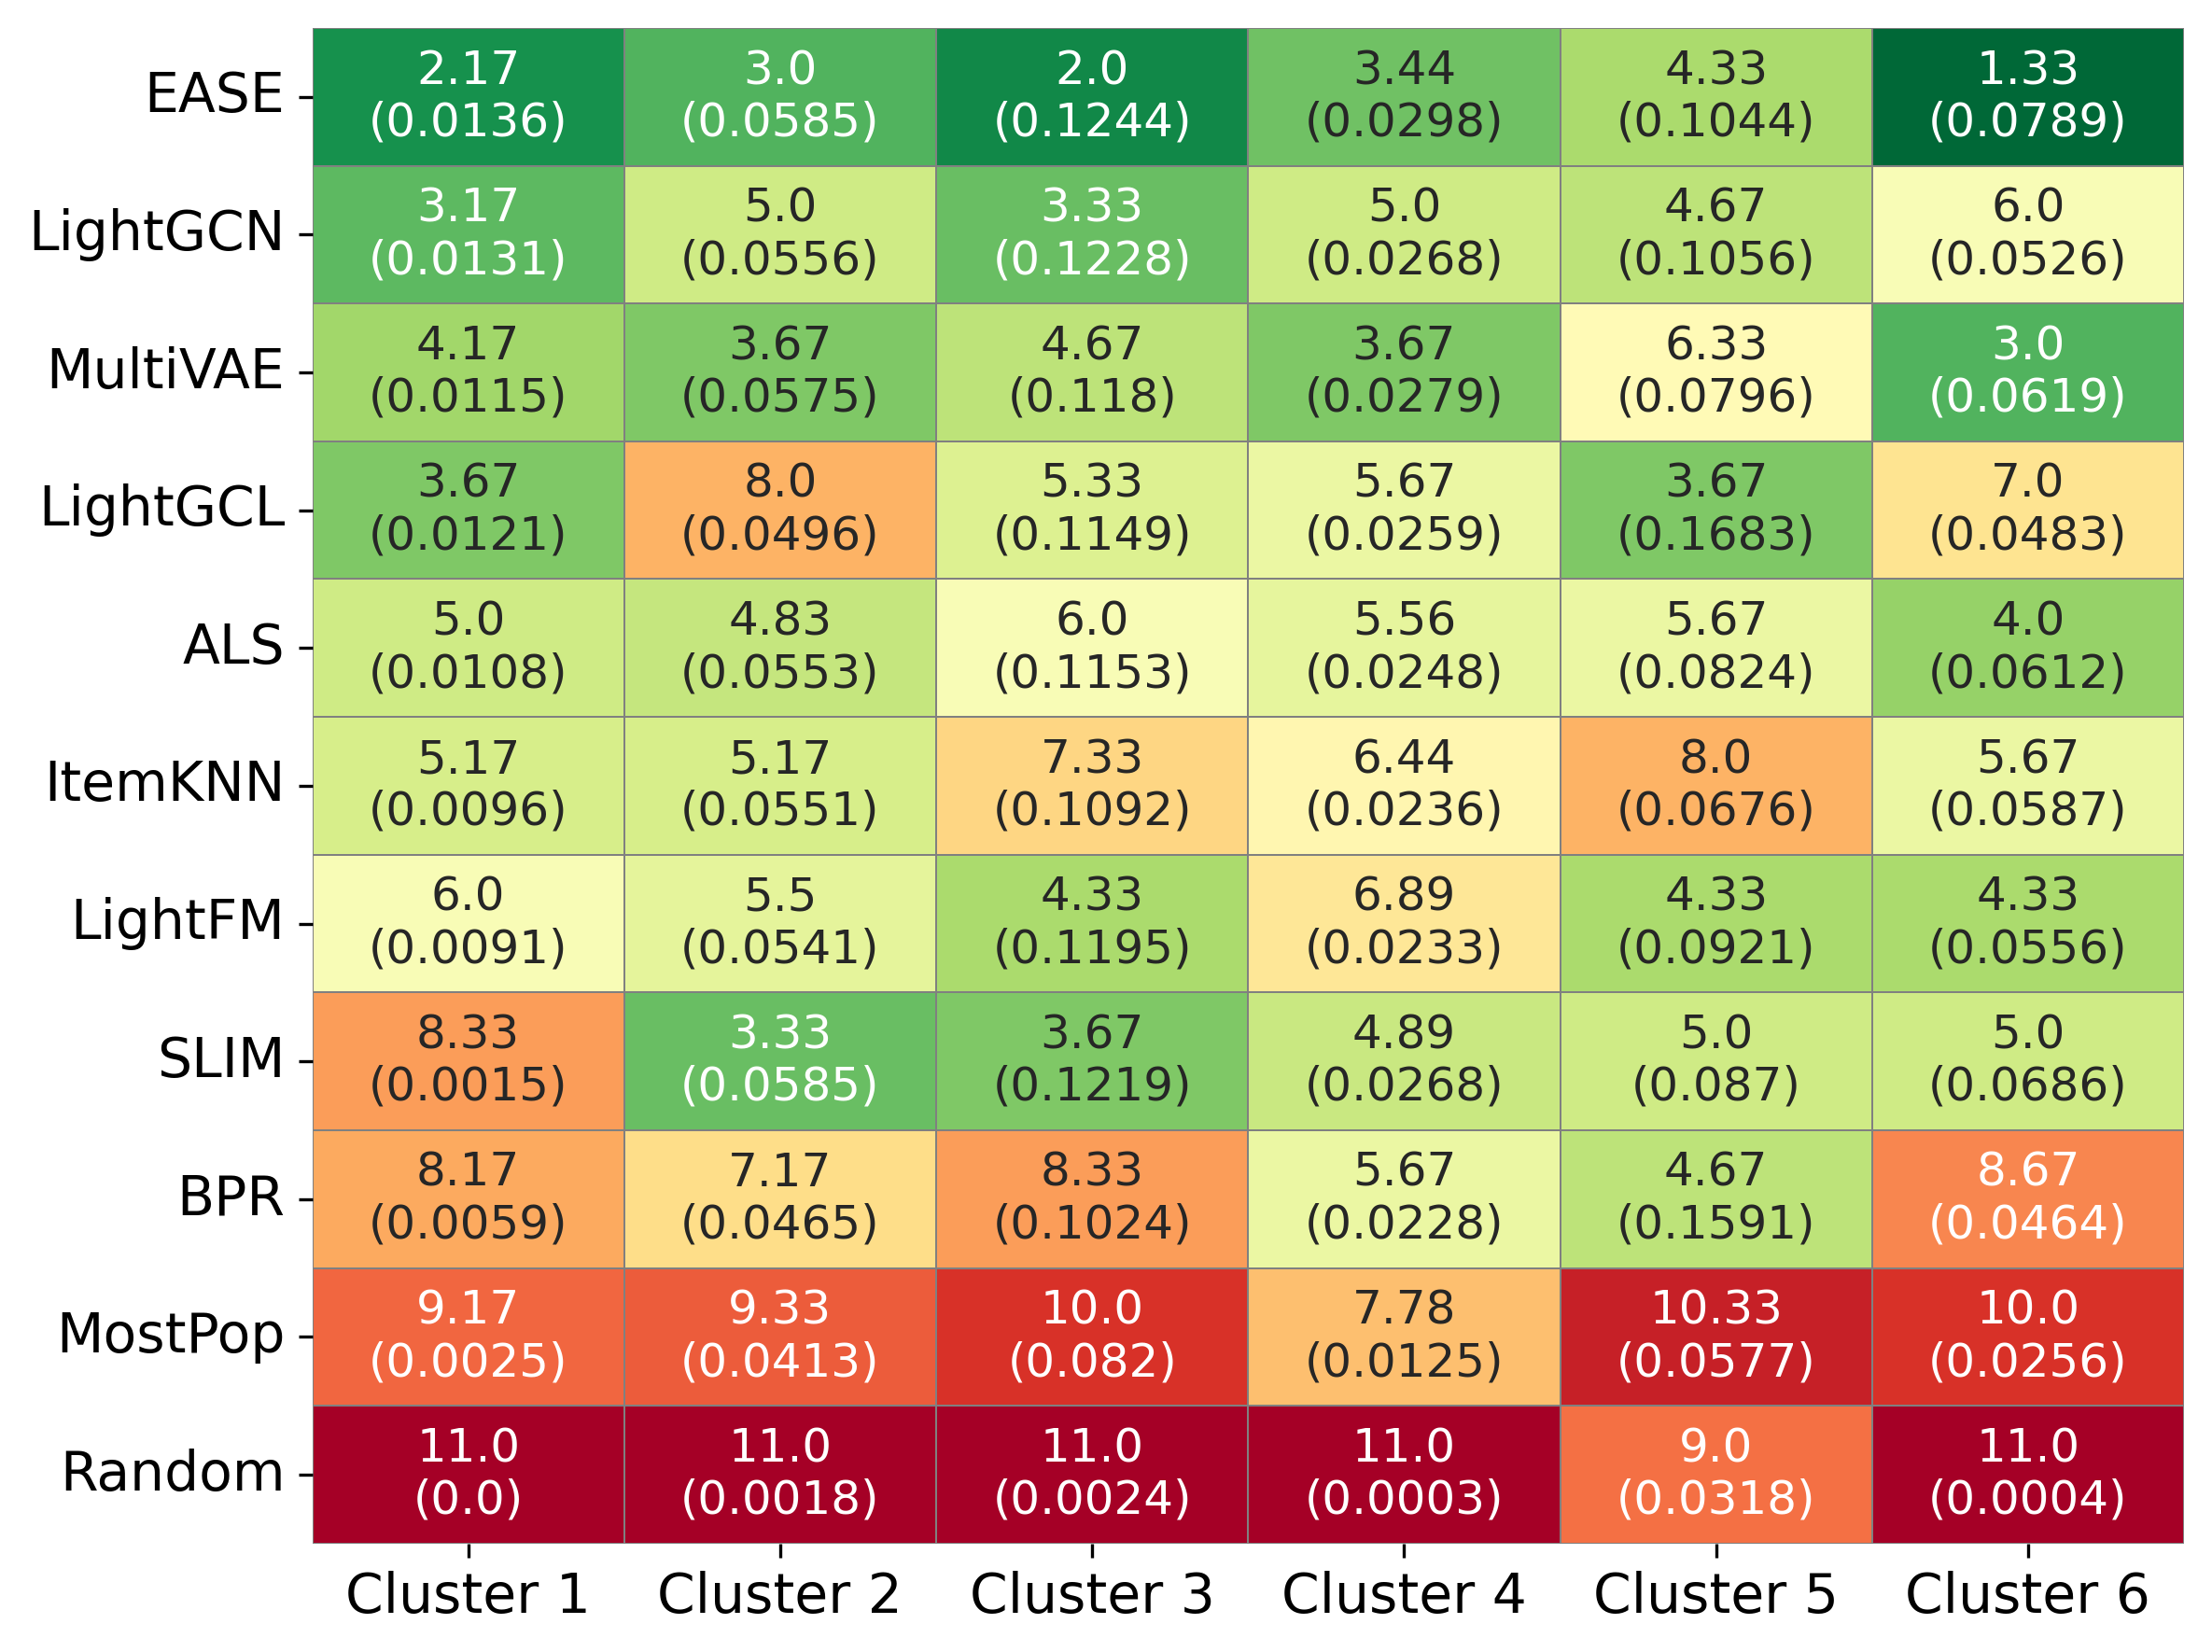

In [7]:
# Define clusters
clusters = {
    f"Cluster {i + 1}": dataset_list for i, dataset_list in enumerate(dataset_clusters)
}

# Initialize DataFrame for aggregated metrics and ranks
aggregated_metrics = pd.DataFrame(index=method_order, columns=clusters.keys())
aggregated_ranks = pd.DataFrame(index=method_order, columns=clusters.keys())

# Aggregate metrics and ranks for each cluster
for cluster_name, datasets in clusters.items():
    cluster_data = pivot_data[datasets]
    cluster_ranks = ranks[datasets]

    # Geometric mean of metrics for the cluster
    aggregated_metrics[cluster_name] = cluster_data.apply(
        lambda x: gmean(x.dropna()), axis=1
    )

    # Mean ranks for the cluster
    aggregated_ranks[cluster_name] = cluster_ranks.mean(axis=1)

# Combine ranks and values for visualization
combined_info_clusters = (
    aggregated_ranks.round(2).astype(str)
    + "\n("
    + aggregated_metrics.round(4).astype(str)
    + ")"
)

# Create the heatmap for clusters
plt.figure(figsize=(8, 6), dpi=300)
sns.heatmap(
    aggregated_ranks,
    annot=combined_info_clusters,
    fmt="",
    cmap="RdYlGn_r",
    linewidths=0.1,
    linecolor="grey",
    cbar=False,
    # cbar_kws={"label": "Mean Rank (Lower is better)", "orientation": "horizontal"},
    annot_kws={"size": 12},
)
# plt.title(
#     "Clustered Performance Heatmap of Methods\n(Mean Rank and Geometric Mean of Metrics)",
#     fontsize=20,
# )
plt.xticks(rotation=0, fontsize=14)
plt.yticks(rotation=0, fontsize=14)
# plt.xlabel("Cluster", fontsize=16)
# plt.ylabel("Method", fontsize=16)
plt.tight_layout()
plt.savefig(
    os.path.join("results", "aggregation", "clusters_ranks.pdf"), bbox_inches="tight"
)
plt.show()

/tmp/ipykernel_600329/3386435235.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_data = pivot_data.pivot("Method", "Dataset", "Value")


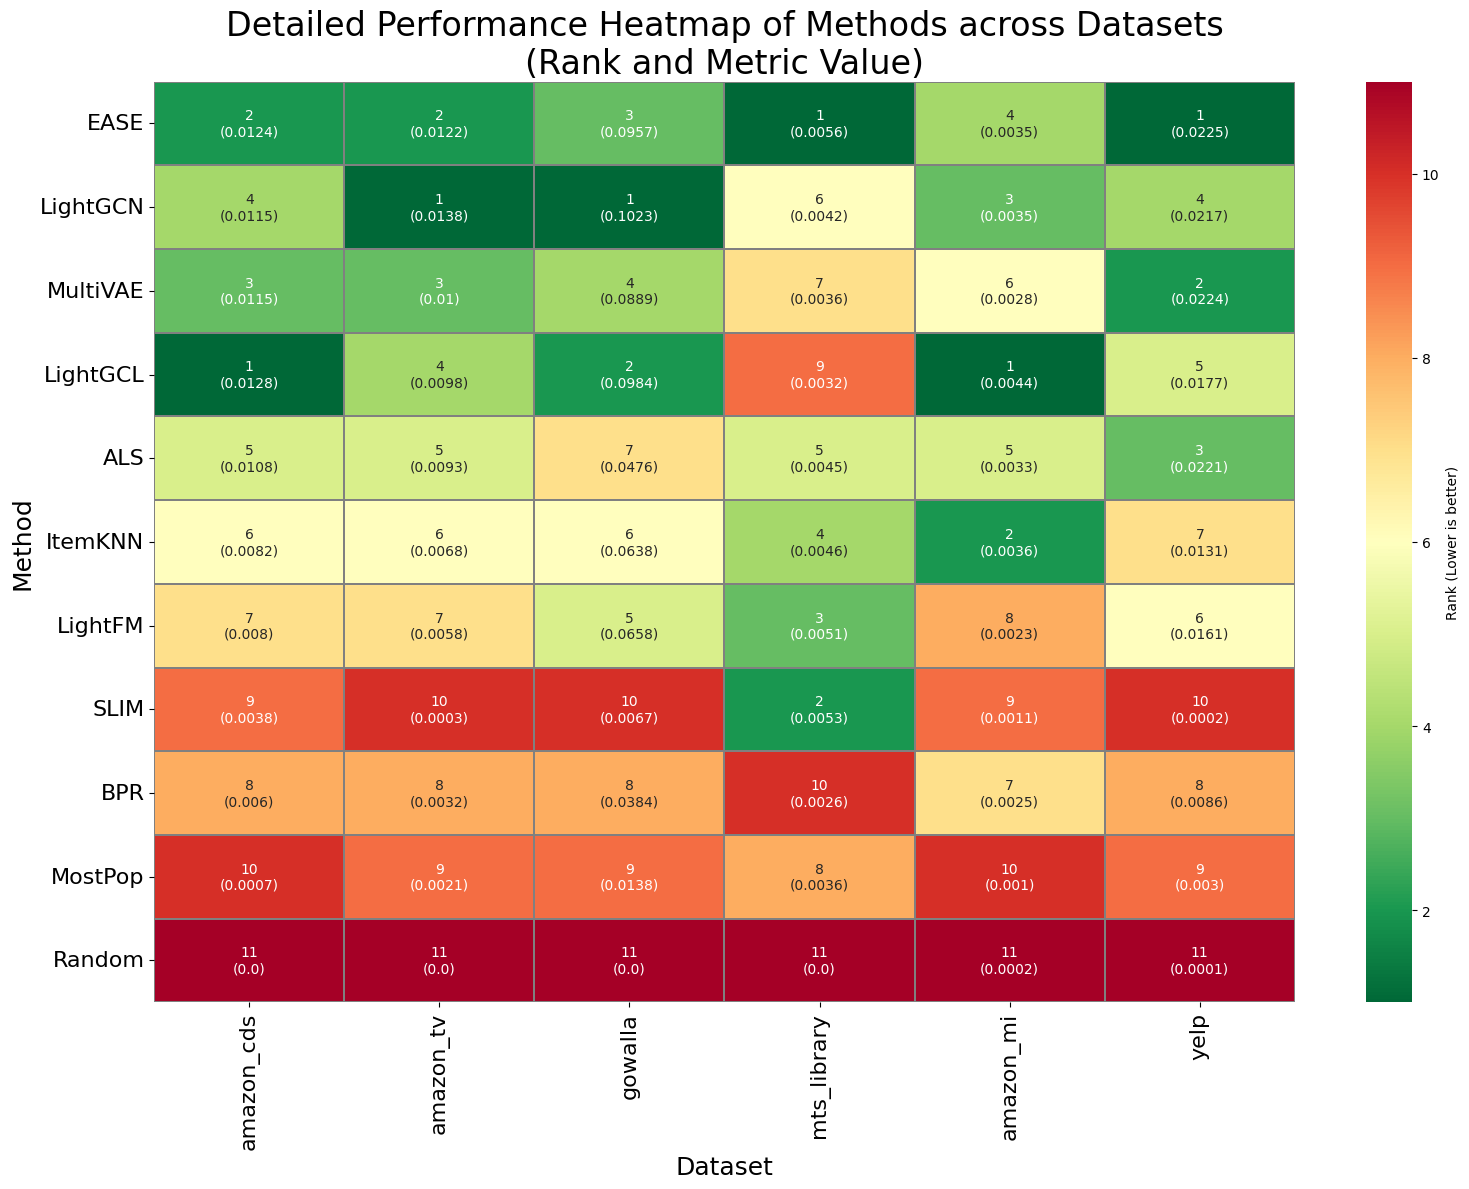

/tmp/ipykernel_600329/3386435235.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_data = pivot_data.pivot("Method", "Dataset", "Value")


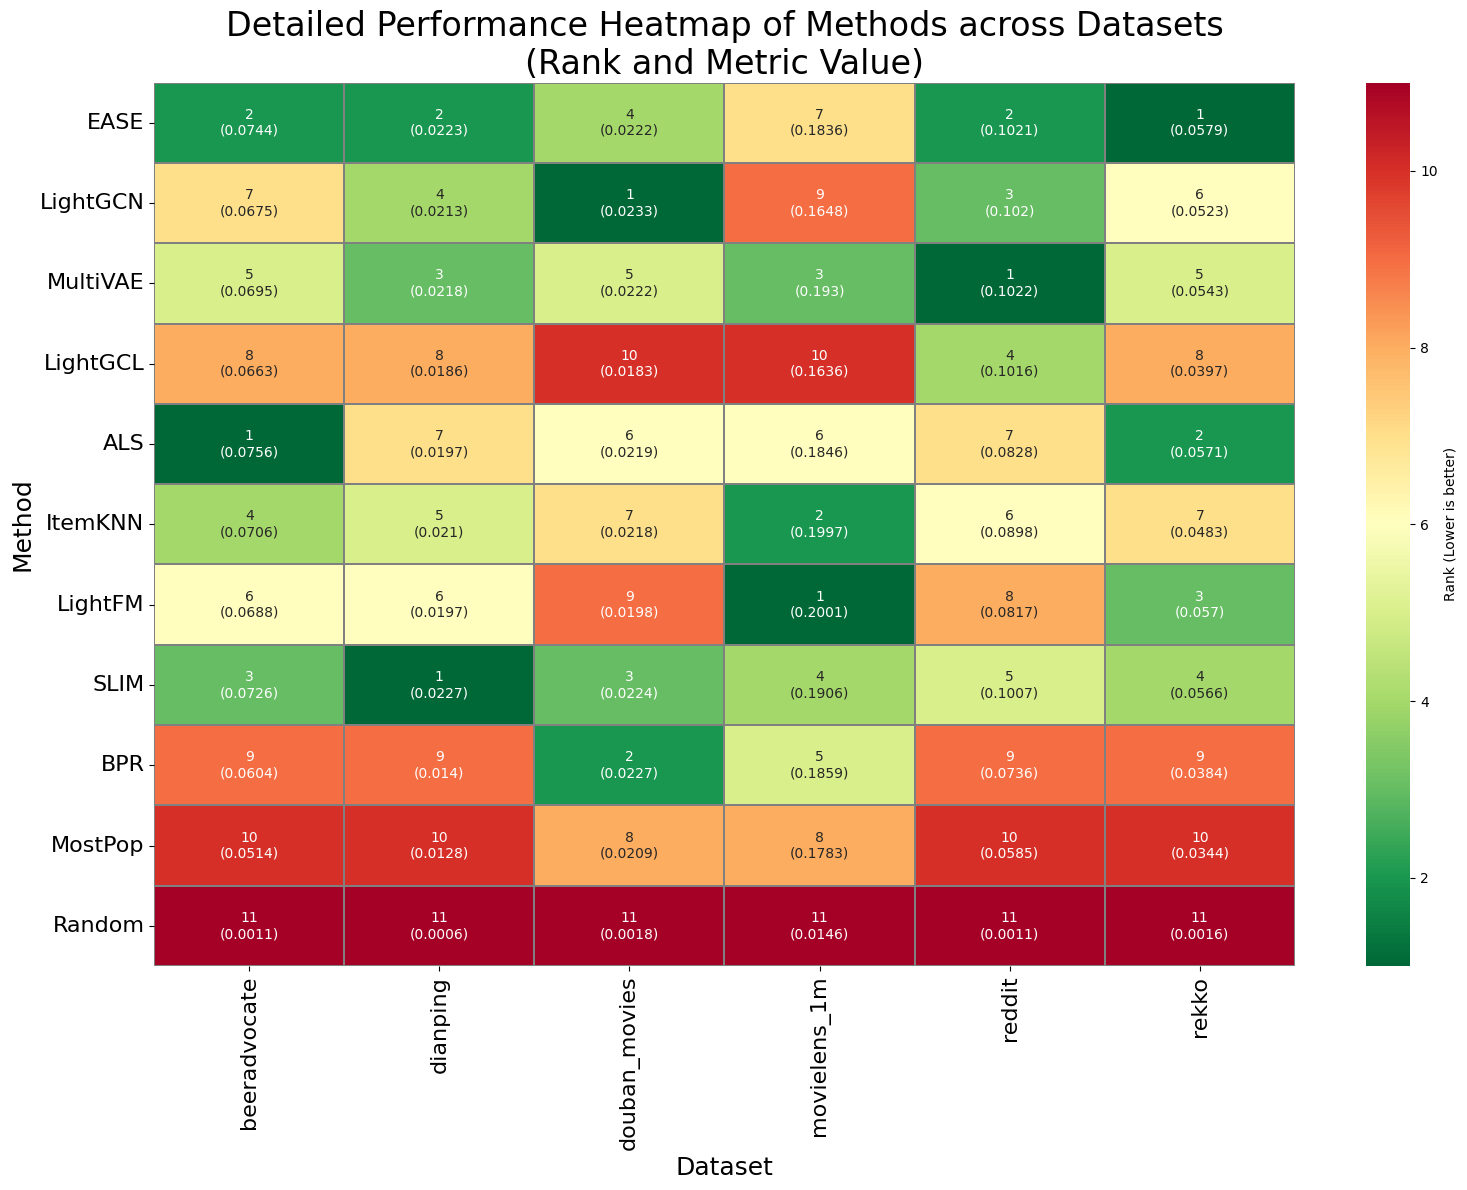

/tmp/ipykernel_600329/3386435235.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_data = pivot_data.pivot("Method", "Dataset", "Value")


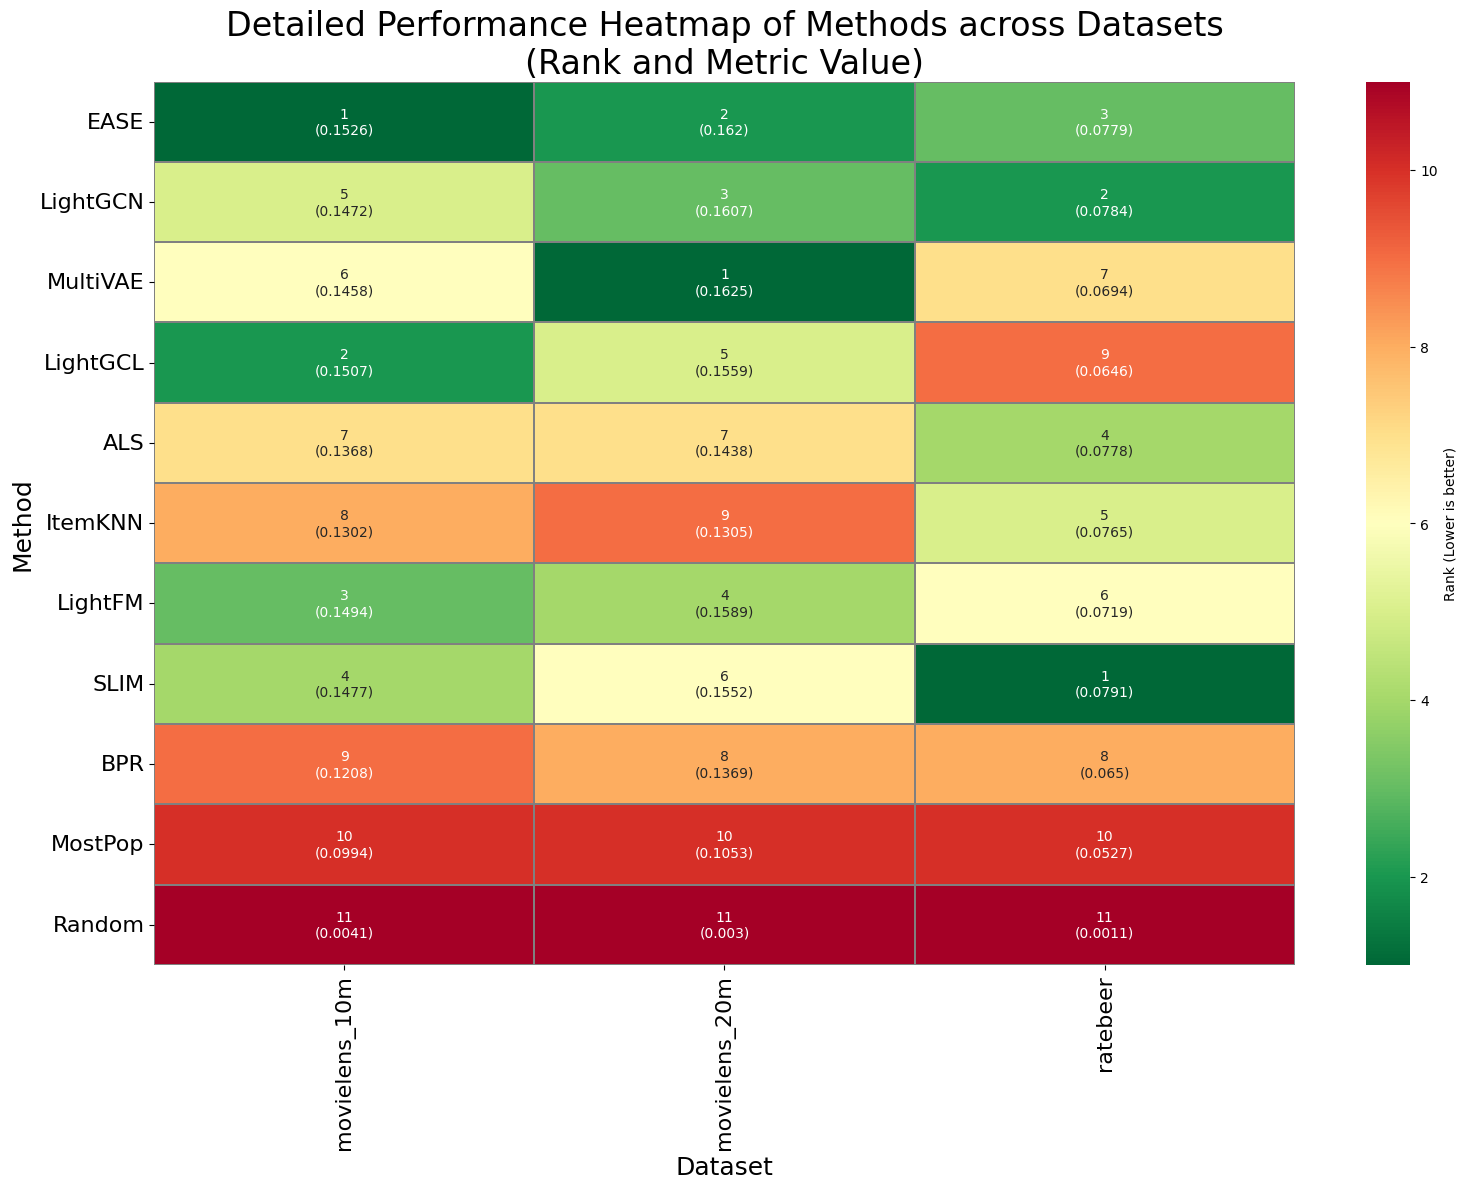

/tmp/ipykernel_600329/3386435235.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_data = pivot_data.pivot("Method", "Dataset", "Value")


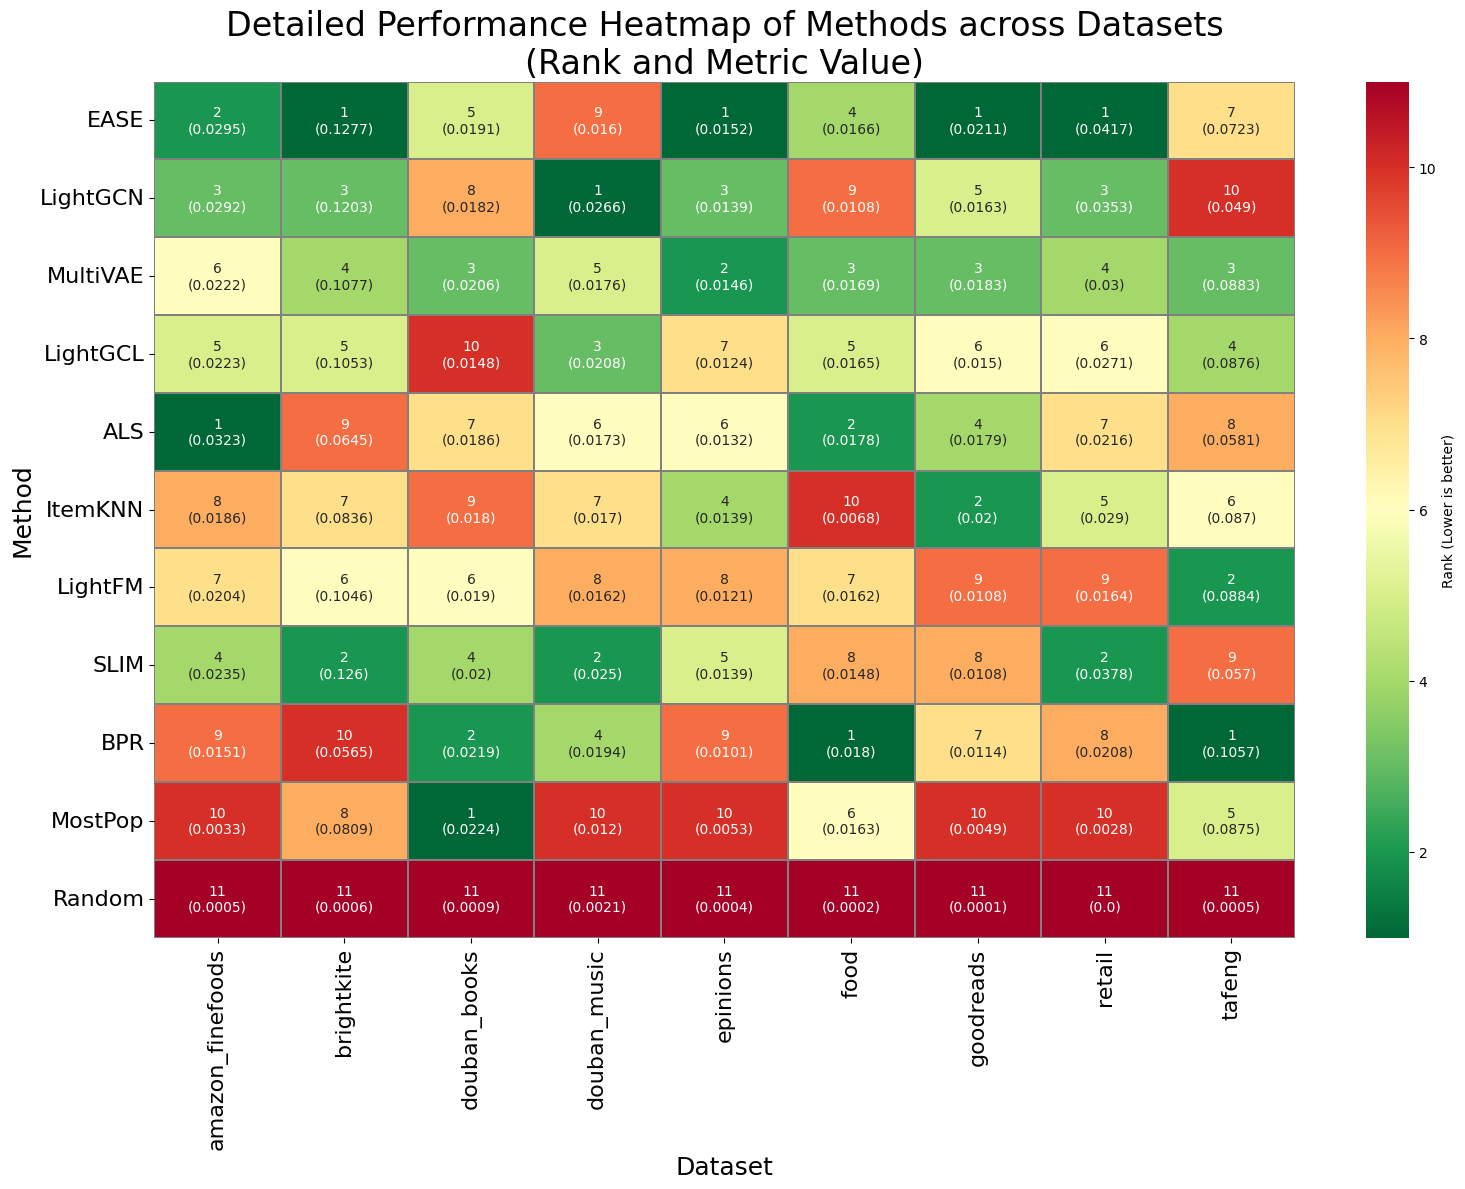

/tmp/ipykernel_600329/3386435235.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_data = pivot_data.pivot("Method", "Dataset", "Value")


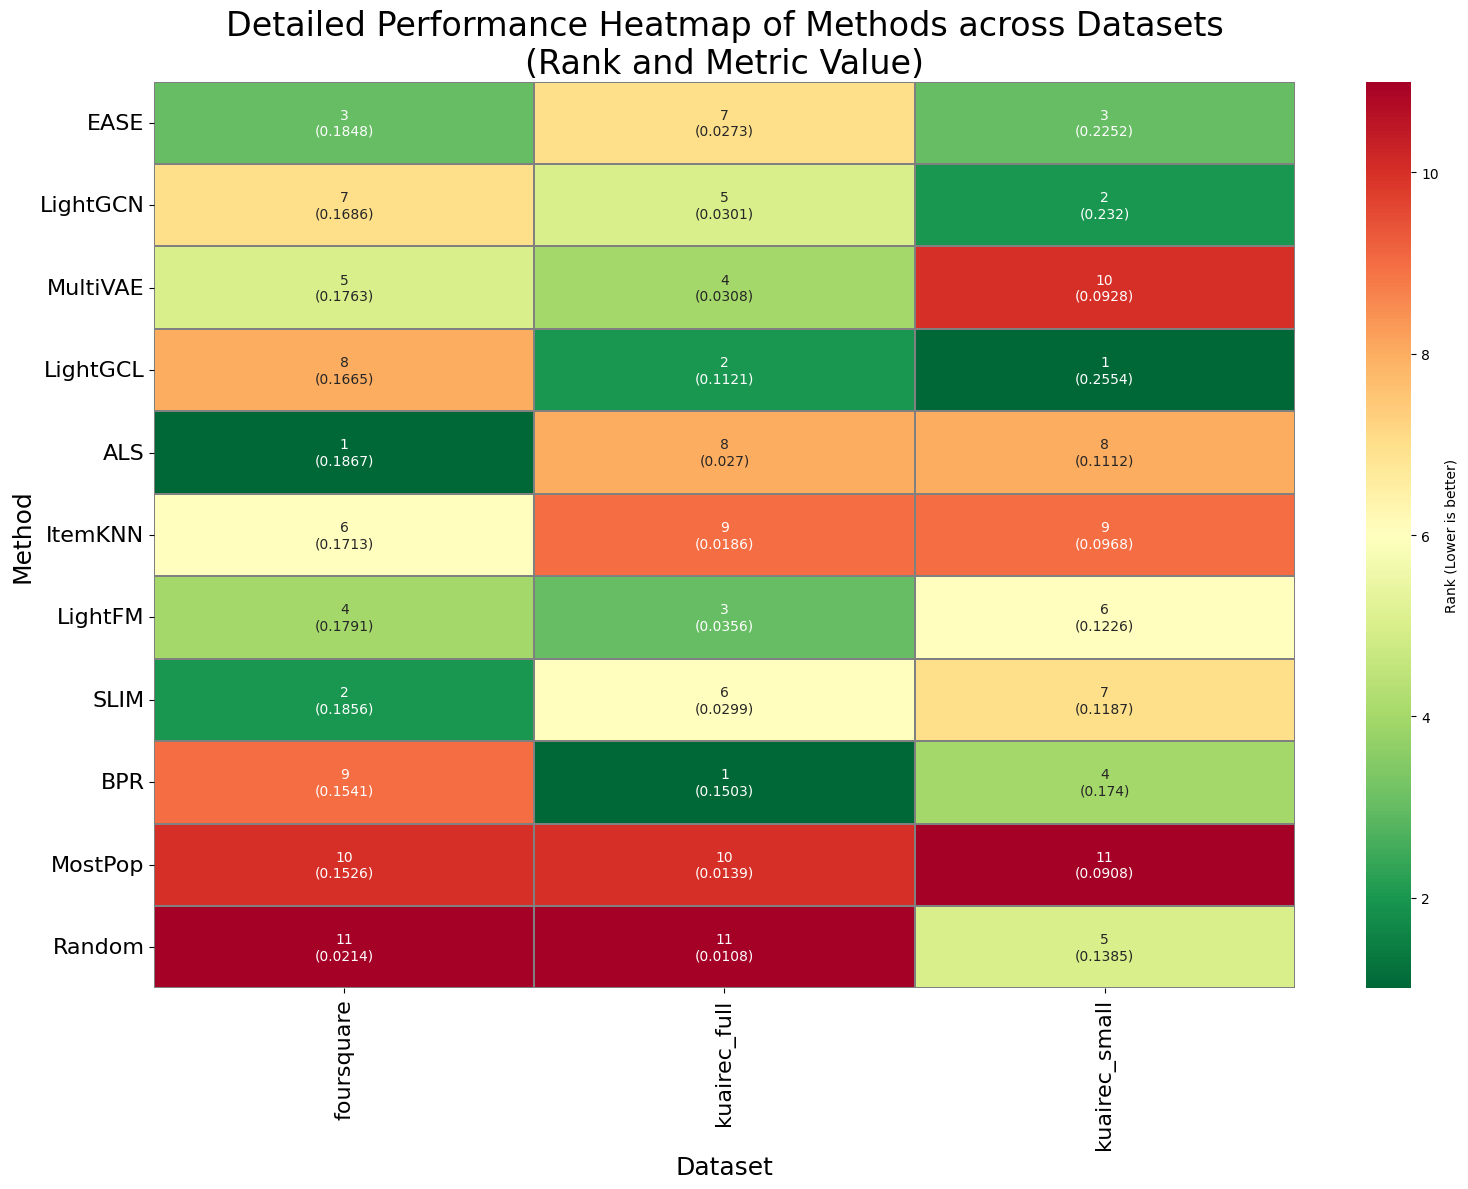

/tmp/ipykernel_600329/3386435235.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_data = pivot_data.pivot("Method", "Dataset", "Value")


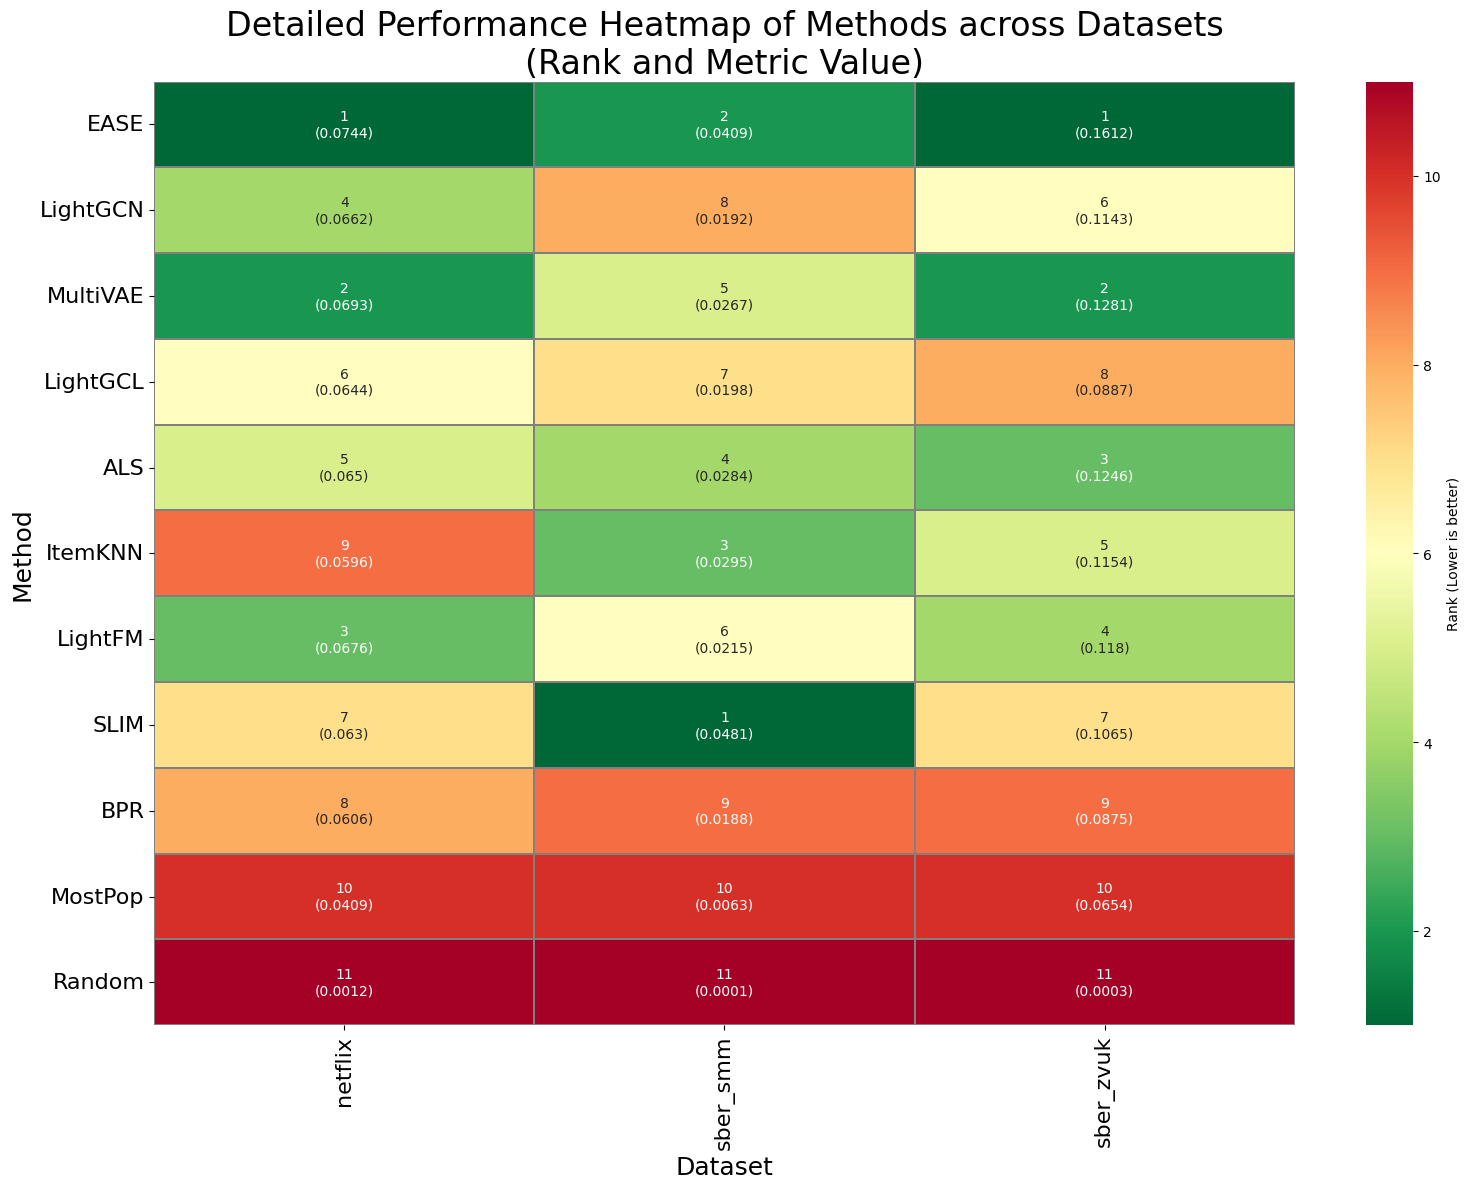

In [8]:
# Pivot the data and sort
# Pivot the data and sort
for cluster in dataset_clusters:
    pivot_data = data[data["Dataset"].isin(cluster)]
    pivot_data = pivot_data.pivot("Method", "Dataset", "Value")
    pivot_data = pivot_data.reindex(method_order, axis=0).reindex(columns=cluster)

    # Calculate ranks across all methods for each dataset
    ranks = pivot_data.apply(lambda x: rankdata(-x, method="min"), axis=0)

    # Combine ranks with metric values for visualization
    combined_info = ranks.astype(str) + "\n(" + pivot_data.round(4).astype(str) + ")"

    # Create the heatmap
    plt.figure(figsize=(16, 12))
    sns.heatmap(
        ranks,
        annot=combined_info,
        fmt="",
        cmap="RdYlGn_r",
        linewidths=0.1,
        linecolor="grey",
        cbar_kws={"label": "Rank (Lower is better)"},
        annot_kws={"size": 10},
    )

    plt.title(
        "Detailed Performance Heatmap of Methods across Datasets\n(Rank and Metric Value)",
        fontsize=24,
    )
    plt.xticks(rotation=90, ha="center", fontsize=16)
    plt.yticks(rotation=0, fontsize=16)
    plt.xlabel("Dataset", fontsize=18)
    plt.ylabel("Method", fontsize=18)
    plt.tight_layout()
    plt.show()